### Imports

In [491]:
#% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from skimage import io, img_as_ubyte
from skimage.transform import resize
import ot

from sklearn import cluster

from tqdm import tqdm

import sys

from utils import MK, monge

import time

## Image Loading and Quantization

In [537]:
n_clusters = 300

In [493]:
source = img_as_ubyte(io.imread('data/Images/ste_victoire.jpg'))
target = img_as_ubyte(io.imread('data/Images/starry_night.jpg'))
reshaped_target = img_as_ubyte(resize(target, source.shape[:2]))

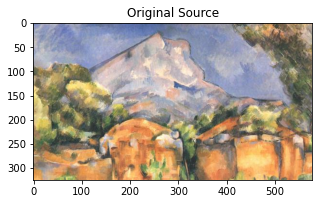

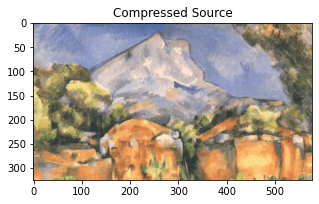

In [494]:
### Kmeans on the source

np.random.seed(0)

X = source.reshape((-1, 3))  # We need an (n_sample, n_feature) array
source_k_means = cluster.MiniBatchKMeans(n_clusters=n_clusters, n_init=4, batch_size=100)
source_k_means.fit(X)
source_values = source_k_means.cluster_centers_.squeeze()
source_labels = source_k_means.labels_

# create an array from labels and values
#source_compressed = np.choose(labels, values)
source_compressed = source_values[source_labels]
source_compressed.shape = source.shape

vmin = source.min()
vmax = source.max()

# original image
plt.figure(1, figsize=(5, 5))
plt.title("Original Source")
plt.imshow(source,  vmin=0, vmax=256)

# compressed image
plt.figure(2, figsize=(5, 5))
plt.title("Compressed Source")
plt.imshow(source_compressed.astype('uint8'),  vmin=0, vmax=256)

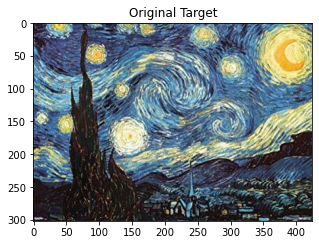

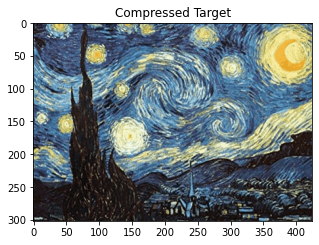

In [495]:
### Kmeans on the target

np.random.seed(0)

X = target.reshape((-1, 3))  # We need an (n_sample, n_feature) array
target_k_means = cluster.MiniBatchKMeans(n_clusters=n_clusters, n_init=4, batch_size=100)
target_k_means.fit(X)
target_values = target_k_means.cluster_centers_.squeeze()
target_labels = target_k_means.labels_

# create an array from labels and values
target_compressed = target_values[target_labels]
target_compressed.shape = target.shape

vmin = target.min()
vmax = target.max()

# original image
plt.figure(1, figsize=(5, 5))
plt.title("Original Target")
plt.imshow(target,  vmin=vmin, vmax=256)

# compressed image
plt.figure(2, figsize=(5, 5))
plt.title("Compressed Target")
plt.imshow(target_compressed.astype('uint8'),  vmin=vmin, vmax=vmax)

## Vanilla transport

In [496]:
s = np.array(source_values).reshape(-1, 3).astype('long')
t = np.array(target_values).reshape(-1, 3).astype('long')

In [497]:
C=ot.dist(s,t)
n = len(s)
a = np.ones(n)
b = np.ones(n)
start_ot = time.time()
P=ot.emd(a,b,C,numItermax=200000)
end_ot = time.time()

print(("Vanilla OT ran in {}s").format(end_ot - start_ot))

Vanilla OT ran in 0.0012631416320800781s


In [498]:
img_ot_transf = ((P@t)[source_labels]).reshape(source.shape).astype('uint8')

(325, 578, 3)
(325, 578, 3)
(325, 578, 3)


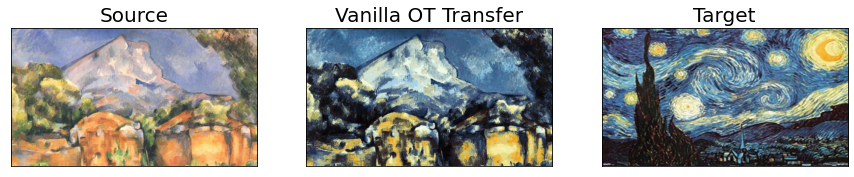

In [499]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))

print(source.shape)
print(img_ot_transf.shape)
print(reshaped_target.shape)

ax[0].imshow(source)
ax[1].imshow(img_ot_transf)
ax[2].imshow(reshaped_target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('Vanilla OT Transfer', fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

# SWGG

In [500]:
from minS_parallel import upperW2
from utils import random_slice,sort_to_plan
import torch
device='cpu'

In [501]:
s = np.array(source_values).reshape(-1, 3).astype('long')
t = np.array(target_values).reshape(-1, 3).astype('long')

X = torch.from_numpy(s).to(device)
Y = torch.from_numpy(t).to(device)

X=X.float()
Y=Y.float()

In [502]:
n_proj=1000
dim=3
theta=random_slice(n_proj,dim).T

In [503]:
start_swgg = time.time()
W,u,v=upperW2(X,Y,theta)
idx=torch.argmin(W)
u=u[:,idx]
v=v[:,idx]
P=sort_to_plan(u,v)
end_swgg = time.time()
print(("SWGG OT ran in {}s").format(end_swgg - start_swgg))

P=P.numpy()

SWGG OT ran in 0.005726814270019531s


In [504]:
img_SWGG_transf = ((P@t)[source_labels]).reshape(source.shape).astype('uint8')

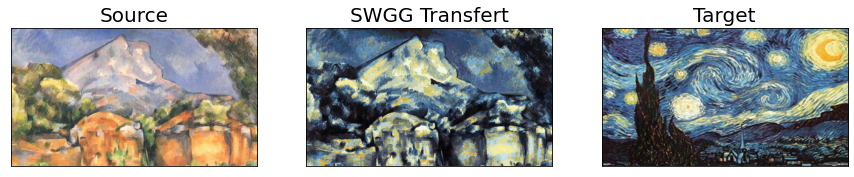

In [505]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(source)
ax[1].imshow(img_SWGG_transf)
ax[2].imshow(reshaped_target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('SWGG Transfert', fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

# smooth SWGG

In [506]:
from minS_Optim import get_minSW_smooth,upperW2_smooth
device='cpu'

In [507]:
s = np.array(source_values).reshape(-1, 3).astype('long')
t = np.array(target_values).reshape(-1, 3).astype('long')

X = torch.from_numpy(s).to(device)
Y = torch.from_numpy(t).to(device)

X=X.float()
Y=Y.float()

100%|██████████████████████| 200/200 [00:00<00:00, 593.37it/s, loss = 12465.070]


SWGG OT ran in 0.34067845344543457s


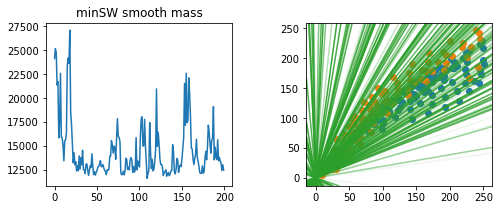

In [527]:
num_iter=200
lr=2e-2
s=50
std=1

start_swggopt = time.time()
theta,loss_smooth_l,proj_smooth_l = get_minSW_smooth(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
theta.requires_grad=False
theta_optim=(theta/torch.norm(theta)).reshape((3,1))

end_swggopt = time.time()
print(("SWGG OT ran in {}s").format(end_swggopt - start_swggopt))

plt.figure(figsize=(8,3))
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0])
plt.plot(loss_smooth_l)
plt.title('minSW smooth mass')

plt.subplot(grid[0, 1])
plt.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
plt.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
for i in range(num_iter):
    plt.axline((0,0), list(proj_smooth_l[i,0:2]), color='C2',alpha=(i/num_iter)**1)


In [528]:
W,u,v=upperW2(X,Y,theta_optim)
P=sort_to_plan(u[:,0],v[:,0])
P=P.numpy()
img_SWGGopt_transf = ((P@t)[source_labels]).reshape(source.shape).astype('uint8')

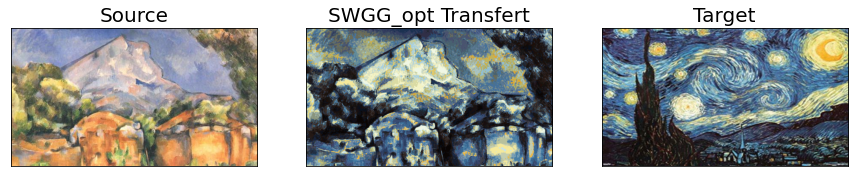

In [529]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(source)
ax[1].imshow(img_SWGGopt_transf)
ax[2].imshow(reshaped_target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('SWGG_opt Transfert', fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

# Grayscale transport

In [530]:
gray_vec = np.array([0.3, 0.59, 0.11])

In [531]:
s = np.array(source_values).reshape(-1, 3).astype('long')
t = np.array(target_values).reshape(-1, 3).astype('long')
print(s.shape)

gray_source = (source_values.dot(gray_vec).astype('long'))
gray_target = (target_values.dot(gray_vec).astype('long'))
print(source_values.shape)
print(gray_source.shape)

(100, 3)
(100, 3)
(100,)


In [532]:
start_mk = time.time()

gray_source_sorted = np.argsort(gray_source)
gray_target_sorted = np.argsort(gray_target)

### 1D OT pairs

gray_transport = np.array(list(zip(gray_source_sorted, gray_target_sorted)))

### Transport disintegrations

gamma_gray = {}

for i in range(len(gray_source_sorted)):
    if gray_source[gray_source_sorted[i]] in gamma_gray:
        gamma_gray[gray_source[gray_source_sorted[i]]].append(gray_transport[i])
    else:
        gamma_gray[gray_source[gray_source_sorted[i]]] = [gray_transport[i]]
        
gray_transf = np.zeros_like(s)

for col in gamma_gray:
    #print(col)
    x, y = np.array(gamma_gray[col]).T
    n = len(x)
    a = b = np.ones(n) / n
    #dists = ((np.delete(s[x], c, 1)[:, None, :] - np.delete(t[y], c, 1))**2).sum(axis=2)
    dists = ((s[x][:, None, :] - t[y])**2).sum(axis=2)
    #print(dists.shape)
    i, j = np.nonzero(ot.emd(a, b,dists))
    gray_transf[x[i]] = t[y[j]]
    
end_mk = time.time()

print(('MK transfer ran in {}s').format(end_mk-start_mk))

MK transfer ran in 0.01961350440979004s


In [533]:
img_gray_transf = gray_transf[source_labels].reshape(source.shape).astype('uint8')

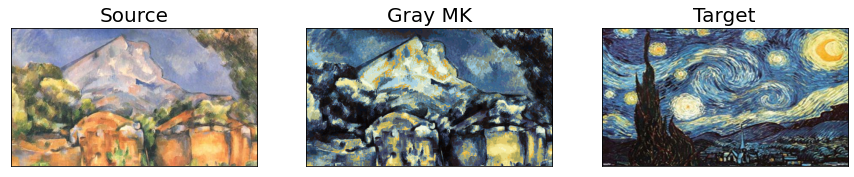

In [534]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))


ax[0].imshow(source)
ax[1].imshow(img_gray_transf)
ax[2].imshow(reshaped_target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title(('Gray MK').format(end_mk - start_mk), fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

# Factored Coupling

Factored Coupling ran in 0.021811485290527344s


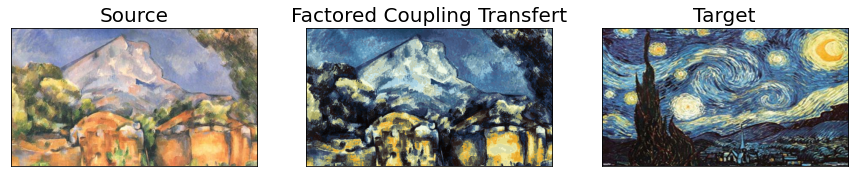

In [535]:
s = np.array(source_values).reshape(-1, 3).astype('long')
t = np.array(target_values).reshape(-1, 3).astype('long')

r=100

C=ot.dist(s,t)
n = len(s)
a = np.ones(n)/n
b = np.ones(n)/n
start_factored = time.time()
Ga, Gb, xb = ot.factored_optimal_transport(s, t, a, b, r=r)
P=(Ga.dot(Gb))*n*n
end_factored = time.time()

print(("Factored Coupling ran in {}s").format(end_factored - start_factored))

img_factored_transf = ((P@t)[source_labels]).reshape(source.shape).astype('uint8')

f, ax = plt.subplots(1, 3, figsize=(15, 10))

ax[0].imshow(source)
ax[1].imshow(img_factored_transf)
ax[2].imshow(reshaped_target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('Factored Coupling Transfert', fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

## Recap

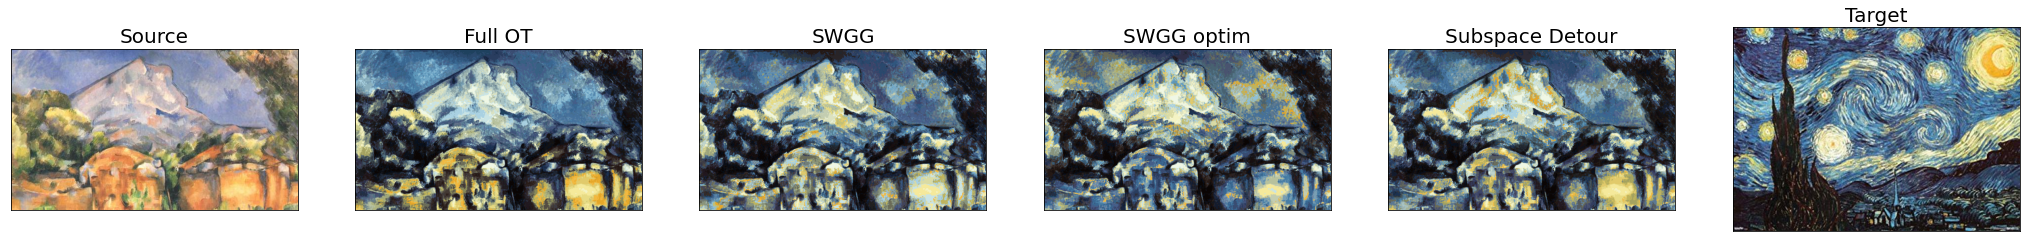

In [536]:
f, ax = plt.subplots(1, 6, figsize=(36, 6))

ax[0].imshow(source)
ax[1].imshow(img_ot_transf)
ax[2].imshow(img_SWGG_transf)
ax[4].imshow(img_gray_transf)
ax[3].imshow(img_SWGGopt_transf)
#ax[4].imshow(img_factored_transf)
ax[5].imshow(target)



ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('Full OT', fontsize = 20)
ax[2].set_title('SWGG' , fontsize = 20)
ax[4].set_title('Subspace Detour', fontsize = 20)
ax[3].set_title('SWGG optim', fontsize = 20)
#ax[4].set_title(('Factored Coupling (runtime {:.2f}s)').format(end_factored - start_factored), fontsize=20)
ax[5].set_title('Target', fontsize = 20)

"""
ax[0].set_title('Source', fontsize = 20)
ax[1].set_title(('Full OT (runtime {:.2f}s)').format(end_ot - start_ot), fontsize = 20)
ax[2].set_title(('SWGG (runtime {:.2f}s)').format(end_swgg - start_swgg), fontsize = 20)
ax[3].set_title(('Subspace Detour (runtime {:.3f}s)').format(end_mk - start_mk), fontsize = 20)
ax[4].set_title(('SWGG optim (runtime {:.2f}s)').format(end_swggopt - start_swggopt), fontsize = 20)
#ax[4].set_title(('Factored Coupling (runtime {:.2f}s)').format(end_factored - start_factored), fontsize=20)
"""
ax[5].set_title('Target', fontsize = 20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)
    
plt.show()